# Single model regression

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from regressor import MLP, QuantileMLP
import glob
from util import UCI
%matplotlib inline
plt.style.use('ggplot')

model_dir = "/mnt/e/models/iso_models"
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:

def plot_solar_regression(fname, model, train_data, test_data, X, y, uncali, conformal):
    plt.scatter(train_data[:,0], train_data[:,1], c='b', label='train')
    plt.scatter(test_data[:,0], test_data[:,1], c='r', label='test')
    label = "mean" if model=="mlp" else "median"
    plt.plot(X, y, c='g', label=label)
    plt.fill_between(X, uncali[0], uncali[1], color="orange", label='uncali.', alpha=0.3)
    plt.fill_between(X, conformal[0], conformal[1], color="blue", label='conformal', alpha=0.4)
    plt.xlim(-230, 230)
    plt.ylim(-3, 3)
    plt.legend()
    # plt.show()
    plt.savefig(f"figures/regression/{fname}.pdf")
    
def predict(model, inputs, device):
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
    
    return outputs

def correct_coverage(refs, lower, upper):
    less_than_upper = refs <= upper
    ref_upper = refs[less_than_upper]
    sub_lower = lower[less_than_upper]
    in_range = ref_upper[ref_upper >= sub_lower]
    return len(in_range)/len(refs)

def correct_coverage1(scores, qhat):
    return (scores <= qhat).mean()

def get_qhat(scores, quantile=0.95):
    n = len(scores)
    # print(scores, np.ceil((n+1)*quantile)/n)
    return np.quantile(scores, np.ceil((n+1)*quantile)/n)

def rmse(predictions, references):
    return np.linalg.norm(predictions - references) / np.sqrt(len(references))

In [77]:
def mlp_score_function(mus, sigmas, refs):
    # project distance from y onto uncertainties
    scores = np.abs(mus - refs) / sigmas
    return scores

def quantile_score_function(lower, upper, refs):
    # project distance from y onto uncertainties
    dists = np.vstack((lower - refs, refs - upper))
    return np.max(dists, axis=0)

In [78]:
def mlp_predict(model_paths, model, inputs, device):
    print(f"Loading model from {model_paths}")
    for path in glob.iglob(model_paths):
        model.load_state_dict(torch.load(path, map_location=device))
        
        mu, log_sigma2 = predict(model, inputs, device)
        sigma = torch.sqrt(torch.exp(log_sigma2))
    
    mu = mu.detach().cpu().numpy()
    sigma = sigma.detach().cpu().numpy()
    if mu.shape[-1] == 1:
        mu = mu.reshape(-1)
    if sigma.shape[-1] == 1:
        sigma = sigma.reshape(-1)
    return mu, sigma

## Solar

In [79]:
train_data = np.load("/mnt/e/data/solar/train.npy")
val_data = np.load("/mnt/e/data/solar/val.npy")
test_data = np.load("/mnt/e/data/solar/test.npy")

train_data.shape, val_data.shape, test_data.shape

((203, 2), (88, 2), (100, 2))

In [80]:
input_dim = 1
output_dim = 1
num_units = 40
drop_prob = 0.01

mlp = MLP(input_dim=input_dim, output_dim=output_dim, num_units=num_units, drop_prob=drop_prob)
print(mlp)

solar_model_paths = os.path.join(model_dir, "mlp", f"mlp_solar_864_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_mus, line_sigmas = mlp_predict(solar_model_paths, mlp, line_X, device)

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_mus.shape, line_sigmas.shape

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.01, inplace=False)
  )
  (mu): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
  (log_sigma2): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_864_*.pt


((4600,), (4600,), (4600,))

In [81]:
line_upper = line_mus + line_sigmas
line_lower = line_mus - line_sigmas
plot_train = np.concatenate((train_data, val_data))

# plot_solar_regression("single/mlp-solar-uncali", "mlp", plot_train, test_data, line_X, line_mus, line_lower, line_upper)

In [82]:
val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_Y = val_data[:, 1]
val_mus, val_sigmas = mlp_predict(solar_model_paths, mlp, val_X, device)

test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_Y = test_data[:, 1]
test_mus, test_sigmas = mlp_predict(solar_model_paths, mlp, test_X, device)

coverage = correct_coverage(val_Y, val_mus-val_sigmas, val_mus+val_sigmas)
print(f"Uncali. coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_mus-test_sigmas, test_mus+test_sigmas)
print(f"Uncali. coverage on test set: {coverage}")

scores = mlp_score_function(val_mus, val_sigmas, val_Y)
qhat = get_qhat(scores, 0.68)
print(f"qhat: {qhat}")

coverage = correct_coverage(val_Y, val_mus-val_sigmas*qhat, val_mus+val_sigmas*qhat)
print(f"Conformal coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_mus-test_sigmas*qhat, test_mus+test_sigmas*qhat)
print(f"Conformal coverage on test set: {coverage}")

Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_864_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_864_*.pt
Uncali. coverage on val set: 0.6590909090909091
Uncali. coverage on test set: 0.64
qhat: 1.05615094575015
Conformal coverage on val set: 0.6931818181818182
Conformal coverage on test set: 0.65


In [83]:
rmse(test_mus, test_Y)

0.3784844160079956

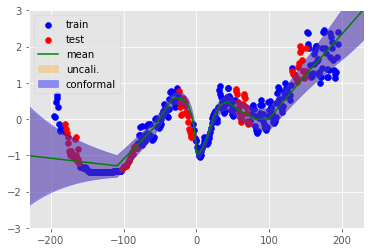

In [84]:
plot_solar_regression("single/mlp-solar-conformal", "mlp", plot_train, test_data, line_X, line_mus, (line_mus-line_sigmas, line_mus+line_sigmas), (line_mus-line_sigmas*qhat, line_mus+line_sigmas*qhat))

## UCI

In [304]:
def UCI_calibration_error(dataset, val_data, test_data, device):
    val_X = torch.from_numpy(val_data[:, :-1]).float()
    val_y = val_data[:, -1]
    test_X = torch.from_numpy(test_data[:, :-1]).float()
    test_y = test_data[:, -1]

    mlp_paths = os.path.join(model_dir, "mlp", f"mlp_{dataset}_864_*.pt")
    mlp = MLP(input_dim=test_X.shape[1], output_dim=1, num_units=200, drop_prob=0.01)
    # print(mlp)

    # print("### Before calibration ###")
    test_mus, test_sigmas = mlp_predict(mlp_paths, mlp, test_X, device)
    uncali_coverage = correct_coverage(test_y, test_mus-test_sigmas, test_mus+test_sigmas)
    # print(f"Coverage: {uncali_coverage}")
    # loss = rmse(test_mus, test_y)
    # print(f"RMSE: {loss}")
    # print()
    
    # print("### Conformal calibrating ###")
    val_mus, val_sigmas = mlp_predict(mlp_paths, mlp, val_X, device)
    scores = mlp_score_function(val_mus, val_sigmas, val_y)
    qhat = get_qhat(scores, 0.68)
    # print(f"qhat: {qhat}")
    coverage = correct_coverage(test_y, test_mus-test_sigmas*qhat, test_mus+test_sigmas*qhat)
    # print(f"Coverage: {coverage}")
    return uncali_coverage, coverage
    
def all_calibration_errors():
    for dataset in UCI:
        val_data = np.load(f"/mnt/e/data/{dataset}/val.npy")
        test_data = np.load(f"/mnt/e/data/{dataset}/test.npy")
        uncali, conformal = UCI_calibration_error(dataset, val_data, test_data, device)
        print(f"{dataset}: {uncali:.4f}, {conformal:.4f}")
        print()


In [305]:
all_calibration_errors()

Loading model from /mnt/e/models/iso_models/mlp/mlp_house_864_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_house_864_*.pt
house: 0.5724, 0.6316

Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_864_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_864_*.pt
concrete: 0.5534, 0.5825

Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_864_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_864_*.pt
energy: 0.5541, 0.5714

Loading model from /mnt/e/models/iso_models/mlp/mlp_power_864_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_power_864_*.pt
power: 0.7168, 0.7011

Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_864_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_864_*.pt
red_wine: 0.6750, 0.7375

Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_864_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_864_*.pt
yacht: 0.8152, 0.7500



# Quantile Regression

In [89]:
def quantile_predict(model_paths, model, inputs, device):
    print(f"Loading model from {model_paths}")
    for path in glob.iglob(model_paths):
        model.load_state_dict(torch.load(path, map_location=device))
        logits = predict(model, inputs, device)

    logits = logits.detach().cpu().numpy()
    if logits.shape[-1] == 1:
        logits = logits.reshape(-1)
    return logits


## Solar

In [90]:
train_data = np.load("/mnt/e/data/solar/train.npy")
val_data = np.load("/mnt/e/data/solar/val.npy")
test_data = np.load("/mnt/e/data/solar/test.npy")
val_data.shape

(88, 2)

In [91]:
model = QuantileMLP(input_dim=1, output_dim=1, num_units=40, drop_prob=0.01)
print(model)

solar_model_paths = os.path.join(model_dir, "quantile", f"quantile_solar_864_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_quantiles = quantile_predict(solar_model_paths, model, line_X, device)
line_y = line_quantiles[:, 1]
line_lower = line_quantiles[:, 0]
line_upper = line_quantiles[:, 2]

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_y.shape, line_lower.shape, line_upper.shape

QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.01, inplace=False)
    (9): Linear(in_features=40, out_features=40, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=40, out_features=3, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_864_*.pt


((4600,), (4600,), (4600,), (4600,))

In [92]:
plot_train = np.concatenate((train_data, val_data))
# plot_solar_regression("single/quantile-solar-uncali", "quantile", plot_train, test_data, line_X, line_y, line_lower, line_upper)

In [93]:
train_X = torch.from_numpy(train_data[:, 0]).float().view(-1, 1)
train_Y = train_data[:, 1]
train_quantiles = quantile_predict(solar_model_paths, model, train_X, device)

val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_Y = val_data[:, 1]
val_quantiles = quantile_predict(solar_model_paths, model, val_X, device)

test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_Y = test_data[:, 1]
test_quantiles = quantile_predict(solar_model_paths, model, test_X, device)

coverage = correct_coverage(val_Y, val_quantiles[:, 0], val_quantiles[:, 2])
print(f"Uncali. coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_quantiles[:, 0], test_quantiles[:, 2])
print(f"Uncali. coverage on test set: {coverage}")

scores = quantile_score_function(val_quantiles[:, 0], val_quantiles[:, 2], val_Y)
qhat = get_qhat(scores, 0.9)
print(f"qhat: {qhat}")

coverage = correct_coverage(val_Y, val_quantiles[:, 0]-qhat, val_quantiles[:, 2]+qhat)
print(f"Conformal coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_quantiles[:, 0]-qhat, test_quantiles[:, 2]+qhat)
print(f"Conformal coverage on test set: {coverage}")

Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_864_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_864_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_864_*.pt
Uncali. coverage on val set: 0.9431818181818182
Uncali. coverage on test set: 0.85
qhat: -0.04300551861524584
Conformal coverage on val set: 0.9204545454545454
Conformal coverage on test set: 0.75


In [94]:
rmse(test_quantiles[:, 1], test_Y)

0.3201675653457642

In [95]:
scores = quantile_score_function(test_quantiles[:, 0], test_quantiles[:, 2], test_Y)
coverage = correct_coverage1(scores, qhat)
coverage # expected coverage: 0.9

0.75

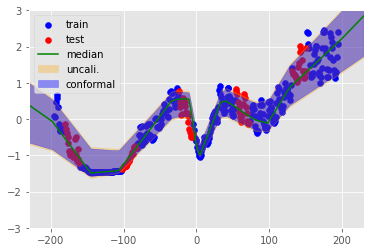

In [96]:
plot_solar_regression("single/quantile-solar-conformal", "quantile", plot_train, test_data, line_X, line_y, (line_lower, line_upper), (line_lower-qhat, line_upper+qhat))

## UCI

In [315]:
def UCI_calibration_quantile(dataset, val_data, test_data, device):
    val_X = torch.from_numpy(val_data[:, :-1]).float()
    val_y = val_data[:, -1]
    test_X = torch.from_numpy(test_data[:, :-1]).float()
    test_y = test_data[:, -1]

    model_paths = os.path.join(model_dir, "quantile", f"quantile_{dataset}_864_*.pt")
    model = QuantileMLP(input_dim=test_X.shape[1], output_dim=1, num_units=200, drop_prob=0.01)
    # print(model)

    # print("### Before calibration ###")
    test_quantiles =quantile_predict(model_paths, model, test_X, device)
    uncali_coverage = correct_coverage(test_y, test_quantiles[:, 0], test_quantiles[:, 2])
    # print(f"Coverage: {coverage}")
    loss = rmse(test_quantiles[:, 1], test_y)
    # print(f"RMSE: {loss}")
    # print()

    # print("### Conformal calibrating ###")
    val_quantiles = quantile_predict(model_paths, model, val_X, device)
    scores = quantile_score_function(val_quantiles[:, 0], val_quantiles[:, 2], val_y)
    qhat = get_qhat(scores, 0.9)
    # print(f"qhat: {qhat}")
    coverage = correct_coverage(test_y, test_quantiles[:, 0]-qhat, test_quantiles[:, 2]+qhat)
    # print(f"Coverage: {coverage}")
    # scores = quantile_score_function(test_quantiles[:, 0], test_quantiles[:, 2], test_y)
    # coverage = correct_coverage1(scores, qhat)
    # print(f"Coverage: {coverage}")
    
    return uncali_coverage, coverage
    
def all_calibration_errors():
    for dataset in UCI:
        val_data = np.load(f"/mnt/e/data/{dataset}/val.npy")
        test_data = np.load(f"/mnt/e/data/{dataset}/test.npy")
        uncali, conformal = UCI_calibration_quantile(dataset, val_data, test_data, device)
        print(f"{dataset}: {uncali:.4f}, {conformal:.4f}")
        print()


In [316]:
all_calibration_errors()

Loading model from /mnt/e/models/iso_models/quantile/quantile_house_864_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_house_864_*.pt
house: 0.7697, 0.8421

Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_864_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_864_*.pt
concrete: 0.7767, 0.7961

Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_864_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_864_*.pt
energy: 0.8571, 0.8485

Loading model from /mnt/e/models/iso_models/quantile/quantile_power_864_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_power_864_*.pt
power: 0.9077, 0.9080

Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_864_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_864_*.pt
red_wine: 0.8375, 0.8854

Loading model from /mnt/e/models/iso_models/quantile/quantile_yacht_864_*.pt
Loading model fro

# Ensembled Regression

In [102]:
def ensemble_mlp_predict(model_paths, model, inputs, device):
    mus, sigmas = [], []
    print(f"Loading model from {model_paths}")
    for path in glob.iglob(model_paths):
        model.load_state_dict(torch.load(path, map_location=device))
        
        mu, log_sigma2 = predict(model, inputs, device)
        sigma = torch.sqrt(torch.exp(log_sigma2))
        mus.append(mu.unsqueeze(0))
        sigmas.append(sigma.unsqueeze(0))
        
    mus = torch.cat(mus, dim=0) # no_model, no_inputs, no_outputs
    sigmas = torch.cat(sigmas, dim=0)
    
    mus = mus.mean(dim=0)
    sigmas = sigmas.mean(dim=0)
    
    mus = mus.detach().cpu().numpy()
    sigmas = sigmas.detach().cpu().numpy()
    if mus.shape[-1] == 1:
        mus = mus.reshape(-1)
    if sigmas.shape[-1] == 1:
        sigmas = sigmas.reshape(-1)
    return mus, sigmas


## Solar

In [103]:
train_data = np.load("/mnt/e/data/solar/train.npy")
val_data = np.load("/mnt/e/data/solar/val.npy")
test_data = np.load("/mnt/e/data/solar/test.npy")

train_data.shape, val_data.shape, test_data.shape

((203, 2), (88, 2), (100, 2))

In [104]:
input_dim = 1
output_dim = 1
num_units = 40
drop_prob = 0.01

mlp = MLP(input_dim=input_dim, output_dim=output_dim, num_units=num_units, drop_prob=drop_prob)
print(mlp)

solar_model_paths = os.path.join(model_dir, "mlp", f"mlp_solar_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_mus, line_sigmas = ensemble_mlp_predict(solar_model_paths, mlp, line_X, device)

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_mus.shape, line_sigmas.shape

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.01, inplace=False)
  )
  (mu): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
  (log_sigma2): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt


((4600,), (4600,), (4600,))

In [105]:
line_upper = line_mus + line_sigmas
line_lower = line_mus - line_sigmas
plot_train = np.concatenate((train_data, val_data))

# plot_solar_regression("ensemble/mlp-solar-uncali", "mlp", plot_train, test_data, line_X, line_mus, line_lower, line_upper)

In [106]:
val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_Y = val_data[:, 1]
val_mus, val_sigmas = ensemble_mlp_predict(solar_model_paths, mlp, val_X, device)

test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_Y = test_data[:, 1]
test_mus, test_sigmas = ensemble_mlp_predict(solar_model_paths, mlp, test_X, device)

coverage = correct_coverage(val_Y, val_mus-val_sigmas, val_mus+val_sigmas)
print(f"Uncali. coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_mus-test_sigmas, test_mus+test_sigmas)
print(f"Uncali. coverage on test set: {coverage}")

scores = mlp_score_function(val_mus, val_sigmas, val_Y)
qhat = get_qhat(scores, 0.68)
print(f"qhat: {qhat}")

coverage = correct_coverage(val_Y, val_mus-val_sigmas*qhat, val_mus+val_sigmas*qhat)
print(f"Conformal coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_mus-test_sigmas*qhat, test_mus+test_sigmas*qhat)
print(f"Conformal coverage on test set: {coverage}")

Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt
Uncali. coverage on val set: 0.6818181818181818
Uncali. coverage on test set: 0.56
qhat: 1.0280274748802185
Conformal coverage on val set: 0.6931818181818182
Conformal coverage on test set: 0.56


In [107]:
rmse(test_mus, test_Y)

0.3386172533035278

In [108]:
scores = mlp_score_function(test_mus, test_sigmas, test_Y)
coverage = correct_coverage1(scores, qhat)
coverage # expected coverage: 0.68

0.56

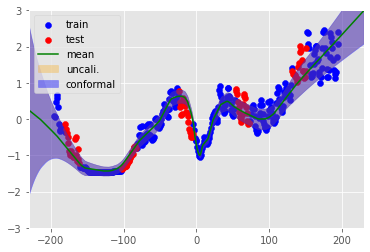

In [109]:
plot_solar_regression("ensemble/mlp-solar-conformal", "mlp", plot_train, test_data, line_X, line_mus, (line_lower, line_upper), (line_mus-line_sigmas*qhat, line_mus+line_sigmas*qhat))

## UCI

In [110]:
def UCI_calibration_error(dataset, val_data, test_data, device):
    val_X = torch.from_numpy(val_data[:, :-1]).float()
    val_y = val_data[:, -1]
    test_X = torch.from_numpy(test_data[:, :-1]).float()
    test_y = test_data[:, -1]

    mlp_paths = os.path.join(model_dir, "mlp", f"mlp_{dataset}_*.pt")
    mlp = MLP(input_dim=test_X.shape[1], output_dim=1, num_units=200, drop_prob=0.01)
    # print(mlp)

    # print("### Before calibration ###")
    test_mus, test_sigmas = ensemble_mlp_predict(mlp_paths, mlp, test_X, device)
    uncali_coverage = correct_coverage(test_y, test_mus-test_sigmas, test_mus+test_sigmas)
    # print(f"Coverage: {coverage}")
    # loss = rmse(test_mus, test_y)
    # print(f"RMSE: {loss}")
    # print()
    
    # print("### Conformal calibrating ###")
    val_mus, val_sigmas = ensemble_mlp_predict(mlp_paths, mlp, val_X, device)
    scores = mlp_score_function(val_mus, val_sigmas, val_y)
    qhat = get_qhat(scores, 0.68)
    # print(f"qhat: {qhat}")
    coverage = correct_coverage(test_y, test_mus-test_sigmas*qhat, test_mus+test_sigmas*qhat)
    # print(f"Coverage: {coverage}")
    
    return uncali_coverage, coverage
    
def all_calibration_errors():
    for dataset in UCI:
        val_data = np.load(f"/mnt/e/data/{dataset}/val.npy")
        test_data = np.load(f"/mnt/e/data/{dataset}/test.npy")
        uncali, conformal = UCI_calibration_error(dataset, val_data, test_data, device)
        print(f"{dataset}: {uncali:.4f}, {conformal:.4f}")
        print()

In [111]:
all_calibration_errors()

Loading model from /mnt/e/models/iso_models/mlp/mlp_house_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_house_*.pt
house: 0.7105, 0.6842

Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_*.pt
concrete: 0.6019, 0.5890

Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_*.pt
energy: 0.6667, 0.6104

Loading model from /mnt/e/models/iso_models/mlp/mlp_power_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_power_*.pt
power: 0.7133, 0.7060

Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_*.pt
red_wine: 0.6917, 0.7271

Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_*.pt
Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_*.pt
yacht: 0.8152, 0.7826



# Quantile Regression

In [112]:
def ensemble_quantile_predict(model_paths, model, inputs, device):
    logits = []
    print(f"Loading model from {model_paths}")
    for path in glob.iglob(model_paths):
        model.load_state_dict(torch.load(path, map_location=device))
        
        o = predict(model, inputs, device)
        logits.append(o.unsqueeze(0))

    logits = torch.cat(logits, dim=0) # no_model, no_inputs, no_outputs
    
    logits = logits.mean(dim=0)

    logits = logits.detach().cpu().numpy()
    if logits.shape[-1] == 1:
        logits = logits.reshape(-1)
    return logits

## Solar

In [113]:
train_data = np.load("/mnt/e/data/solar/train.npy")
val_data = np.load("/mnt/e/data/solar/val.npy")
test_data = np.load("/mnt/e/data/solar/test.npy")
val_data.shape

(88, 2)

In [114]:
model = QuantileMLP(input_dim=1, output_dim=1, num_units=40, drop_prob=0.01)
print(model)

solar_model_paths = os.path.join(model_dir, "quantile", f"quantile_solar_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_quantiles = ensemble_quantile_predict(solar_model_paths, model, line_X, device)
line_y = line_quantiles[:, 1]
line_lower = line_quantiles[:, 0]
line_upper = line_quantiles[:, 2]

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_y.shape, line_lower.shape, line_upper.shape

QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.01, inplace=False)
    (9): Linear(in_features=40, out_features=40, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=40, out_features=3, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt


((4600,), (4600,), (4600,), (4600,))

In [115]:
plot_train = np.concatenate((train_data, val_data))
# plot_solar_regression("ensemble/quantile-solar-uncali", "quantile", plot_train, test_data, line_X, line_y, line_lower, line_upper)

In [116]:
train_X = torch.from_numpy(train_data[:, 0]).float().view(-1, 1)
train_Y = train_data[:, 1]
train_quantiles = ensemble_quantile_predict(solar_model_paths, model, train_X, device)

val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_Y = val_data[:, 1]
val_quantiles = ensemble_quantile_predict(solar_model_paths, model, val_X, device)

test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_Y = test_data[:, 1]
test_quantiles = ensemble_quantile_predict(solar_model_paths, model, test_X, device)

coverage = correct_coverage(val_Y, val_quantiles[:, 0], val_quantiles[:, 2])
print(f"Uncali. coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_quantiles[:, 0], test_quantiles[:, 2])
print(f"Uncali. coverage on test set: {coverage}")

scores = quantile_score_function(val_quantiles[:, 0], val_quantiles[:, 2], val_Y)
qhat = get_qhat(scores, 0.9)
print(f"qhat: {qhat}")

coverage = correct_coverage(val_Y, val_quantiles[:, 0]-qhat, val_quantiles[:, 2]+qhat)
print(f"Conformal coverage on val set: {coverage}")
coverage = correct_coverage(test_Y, test_quantiles[:, 0]-qhat, test_quantiles[:, 2]+qhat)
print(f"Conformal coverage on test set: {coverage}")

Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt
Uncali. coverage on val set: 0.9545454545454546
Uncali. coverage on test set: 0.87
qhat: -0.05194368890740659
Conformal coverage on val set: 0.9204545454545454
Conformal coverage on test set: 0.83


In [117]:
rmse(test_quantiles[:, 1], test_Y)

0.29558889865875243

In [118]:
scores = quantile_score_function(test_quantiles[:, 0], test_quantiles[:, 2], test_Y)
coverage = correct_coverage1(scores, qhat)
coverage # expected coverage: 0.9

0.83

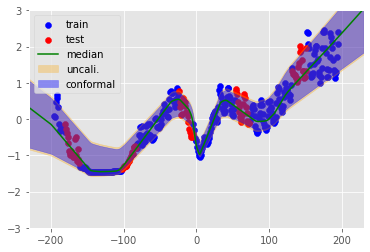

In [119]:
plot_solar_regression("ensemble/quantile-solar-conformal", "quantile", plot_train, test_data, line_X, line_y, (line_lower, line_upper), (line_lower-qhat, line_upper+qhat))

## UCI

In [336]:
def UCI_calibration_quantile(dataset, val_data, test_data, device):
    val_X = torch.from_numpy(val_data[:, :-1]).float()
    val_y = val_data[:, -1]
    test_X = torch.from_numpy(test_data[:, :-1]).float()
    test_y = test_data[:, -1]

    model_paths = os.path.join(model_dir, "quantile", f"quantile_{dataset}_*.pt")
    model = QuantileMLP(input_dim=test_X.shape[1], output_dim=1, num_units=200, drop_prob=0.01)
    # print(model)

    # print("### Before calibration ###")
    test_quantiles = ensemble_quantile_predict(model_paths, model, test_X, device)
    uncali_coverage = correct_coverage(test_y, test_quantiles[:, 0], test_quantiles[:, 2])
    # print(f"Coverage: {coverage}")
    # loss = rmse(test_quantiles[:, 1], test_y)
    # print(f"RMSE: {loss}")
    # print()

    # print("### Conformal calibrating ###")
    val_quantiles = ensemble_quantile_predict(model_paths, model, val_X, device)
    scores = quantile_score_function(val_quantiles[:, 0], val_quantiles[:, 2], val_y)
    qhat = get_qhat(scores, 0.9)
    # print(f"qhat: {qhat}")
    coverage = correct_coverage(test_y, test_quantiles[:, 0]-qhat, test_quantiles[:, 2]+qhat)
    # print(f"Coverage: {coverage}")
    # scores = quantile_score_function(test_quantiles[:, 0], test_quantiles[:, 2], test_y)
    # coverage = correct_coverage1(scores, qhat)
    # print(f"Coverage: {coverage}")
    
    return uncali_coverage, coverage
    
def all_calibration_errors():
    for dataset in UCI:
        val_data = np.load(f"/mnt/e/data/{dataset}/val.npy")
        test_data = np.load(f"/mnt/e/data/{dataset}/test.npy")
        uncali, conformal = UCI_calibration_quantile(dataset, val_data, test_data, device)
        print(f"{dataset}: {uncali:.4f}, {conformal:.4f}")
        print()


In [337]:
all_calibration_errors()

Loading model from /mnt/e/models/iso_models/quantile/quantile_house_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_house_*.pt
house: 0.8092, 0.8618

Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_*.pt
concrete: 0.7896, 0.7994

Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_*.pt
energy: 0.8615, 0.8485

Loading model from /mnt/e/models/iso_models/quantile/quantile_power_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_power_*.pt
power: 0.9035, 0.9053

Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_*.pt
red_wine: 0.8625, 0.9000

Loading model from /mnt/e/models/iso_models/quantile/quantile_yacht_*.pt
Loading model from /mnt/e/models/iso_models/quantile/quantile